Importing library

In [1]:
import os
from astropy.io import fits
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
from tensorflow_probability.python.distributions import kl_divergence

In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/extra_files/five_band_image127x127_full.hdf5', 'r')
n = 10000
x = []
y = []
r = random.sample(range(len(hf["specz"])), n)
x = [hf["image"][i] for i in r]
y = np.asarray([hf["specz"][i] for i in r])
x = np.transpose(x,(0,2,3,1))
max_value = np.max(x)
x_new = np.true_divide(x,max_value)
hf.close()

Importing data

Image Augmentation

In [6]:
##datagen = ImageDataGenerator(rotation_range=90)
##it = datagen.flow(x_new, batch_size=1)

In [7]:
x_train ,x_test,y_train,y_test = train_test_split(x_new,y,test_size=0.2)

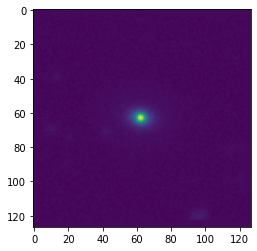

In [12]:
plt.imshow(x_test[0][:,:,0])

In [14]:
x_test[0][:,:,0][60].mean()

0.0001218646

In [15]:
np.max(y_train)

3.88661003

In [ ]:
import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Input(shape=(127,127,5)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='tanh'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(2,2),activation='tanh'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(32, kernel_size=(2,2),activation='relu'))
model.add(Flatten())
model.add(Dense(500, activation="tanh"))
model.add(Dense(100, activation="tanh"))
model.add(Dense(1))

model.build((127,127,5))
model.summary()

In [ ]:
# From Evan's code, didn't completely understand this part
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= 0 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=0.1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [ ]:
model_variational = Sequential([
    tf.keras.layers.Input(shape=(127,127,5)),
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    Conv2D(32, kernel_size=(2,2),activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(32, kernel_size=(2,2),activation='relu'),
    #tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', kernel_divergence_fn=kl_divergence_function),
    Conv2D(32, kernel_size=(2,2),activation='relu'),
    #tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.Flatten(),
    Dropout(0.2),
    # tfp.layers.DenseVariational(512, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    tfp.layers.DenseVariational(64, 
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1/n),
    # tfp.layers.DenseVariational(128, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    tfp.layers.DenseVariational(64, 
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1/n),
    # Dense(2)
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_variational.summary()

model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.fit(x_train,y_train,epochs=300,shuffle = True,verbose=1)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse",metrics=[keras.metrics.RootMeanSquaredError()])

model.fit(x_train,y_train,epochs=300,shuffle = True,verbose=1)

In [ ]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)*1/(1 + targets)

model_variational.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = negative_loglikelihood, metrics=[keras.metrics.RootMeanSquaredError()])

model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
model_variational.fit(x = x_train, y = y_train, epochs = 600, shuffle = True, verbose=1)

In [ ]:
y_test_prediction = []

for i in range(len(y_test)):
    y_test_prediction.append(model_variational(np.array([x_test[i]])).mean()[0][0])

y_test_prediction = np.asarray(y_test_prediction).astype('float32')

y_test_spectro = np.asarray(y_test[:,0])

In [ ]:
y_t_p = model.predict(x_test)
y_t_p_cnn = []

for i in range(len(y_test)):
    y_t_p_cnn.append(y_t_p[i][0])

y_t_p_cnn = np.asarray(y_t_p_cnn).astype('float32')

In [ ]:
y_test_std = []

for i in range(len(y_test)):
    y_test_std.append(model_variational(np.array([x_test[i]])).stddev()[0][0])

y_test_prediction = model.predict(x_test)[:,0]

y_test_prediction = np.asarray(y_test_prediction).astype('float32')

y_test_spectro = np.asarray(y_test[:,0])

In [ ]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_spectro, y_test_prediction])).astype('float32')
z = gaussian_kde(xy)(xy)

In [ ]:
xy_cnn = np.asarray(np.vstack([y_test_spectro, y_t_p_cnn])).astype('float32')
z_cnn = gaussian_kde(xy_cnn)(xy_cnn)

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 10), 'lines.markersize':20})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_spectro, y_test_prediction, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('BNN Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 2], [0, 2],color = 'black')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.show()

In [ ]:
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_spectro, y_t_p_cnn, c = z_cnn, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('CNN Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 2], [0, 2],color = 'black')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.show()

In [ ]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0,len(y_test)):
    if np.abs(y_test_spectro[i]-y_test_prediction[i])<=y_test_std[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)

In [ ]:
fig, ax = plt.subplots()
display_size = 300
scatter_plot = ax.scatter(y_test_spectro[:display_size], y_test_prediction[:display_size], c = z[:display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(y_test_spectro[:display_size], y_test_prediction[:display_size], yerr = y_test_std[:display_size], fmt="o", markersize=0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction with error, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 2], [0, 2],color = 'black')
plt.xlim([0, 2])
plt.ylim([0, 2])
print("Coverage: "+str(overlap_variational/len(y_test)))

In [ ]:
combined_array = np.transpose(np.vstack((y_test_spectro, y_t_p_cnn))) 
sorted_combined_array = sorted(combined_array, key=lambda x: x[0])

In [ ]:
combined_array_variational = np.transpose(np.vstack((y_test_spectro, y_test_prediction, y_test_std, overlap_array_variational))) 

In [ ]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x: x[0])

In [ ]:
z_max = 2
bins_variational = int(z_max*5)
splitted_sorted_combined_array = np.array_split(sorted_combined_array, bins_variational)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational, bins_variational)
coverage_variational = []
for i in range(0, bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational/len(splitted_sorted_combined_array_variational[i])/0.6827)
x_array = np.arange(0, z_max, z_max/bins_variational)

In [ ]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.title('Coverage, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0, 1.5])
print("Coverage: "+str(overlap_variational/len(y_test)))

In [ ]:
mean_array = []
for i in range(0, bins_variational):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array_variational[i])):
        bias = (splitted_sorted_combined_array_variational[i][j][1]-splitted_sorted_combined_array_variational[i][j][0])
        total += bias
    mean_array.append(total/len(splitted_sorted_combined_array_variational[i]))
x_array = np.arange(0, z_max, z_max/bins_variational)

In [ ]:
mean_array_cnn = []
for i in range(0, bins_variational):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array[i])):
        bias = (splitted_sorted_combined_array[i][j][1]-splitted_sorted_combined_array[i][j][0])
        total += bias
    mean_array_cnn.append(total/len(splitted_sorted_combined_array[i]))

In [ ]:
error_array = []
for i in range(0,bins_variational):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        error_total += splitted_sorted_combined_array_variational[i][j][2]
    error_array.append(error_total/len(splitted_sorted_combined_array_variational[i]))

In [ ]:
sns.set(rc={'figure.figsize':(5, 5), 'lines.markersize':40})
plt.rcParams.update({'font.size': 40})
plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2, zorder = 1, label = 'Bayesian')
plt.scatter(x_array, mean_array_cnn,  color = 'orange', s = 4, zorder = 2, label = 'CNN')
plt.title('Bias Plot for Probabilistic Model')
plt.xlabel('True Redshift')
plt.ylabel('Bias (Predicted - True)')
plt.plot([0, 2], [0, 0],color = 'black')
plt.ylim([-1, 1])
plt.legend()
plt.show()

In [ ]:
# END